## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
from nltk.tokenize import word_tokenize
from functools import reduce
import random
import re

In [2]:
# nltk.download('averaged_perceptron_tagger')

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print(nltk_data[5])

[('Lorillard', 'NOUN'), ('Inc.', 'NOUN'), (',', '.'), ('the', 'DET'), ('unit', 'NOUN'), ('of', 'ADP'), ('New', 'ADJ'), ('York-based', 'ADJ'), ('Loews', 'NOUN'), ('Corp.', 'NOUN'), ('that', 'DET'), ('*T*-2', 'X'), ('makes', 'VERB'), ('Kent', 'NOUN'), ('cigarettes', 'NOUN'), (',', '.'), ('stopped', 'VERB'), ('using', 'VERB'), ('crocidolite', 'NOUN'), ('in', 'ADP'), ('its', 'PRON'), ('Micronite', 'NOUN'), ('cigarette', 'NOUN'), ('filters', 'NOUN'), ('in', 'ADP'), ('1956', 'NUM'), ('.', '.')]


In [4]:
#help(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [5]:
# splitting Treebank dataset into train & validation set in the ratio of 95:5 %
random.seed(0)
train_set, validation_set = train_test_split(nltk_data,train_size=0.95,test_size=0.05,random_state=50)

In [6]:
train_set[:3]

[[('The', 'DET'),
  ('problem', 'NOUN'),
  ('involves', 'VERB'),
  ('the', 'DET'),
  ('motion', 'NOUN'),
  ('of', 'ADP'),
  ('small', 'ADJ'),
  ('magnetic', 'ADJ'),
  ('fields', 'NOUN'),
  ('within', 'ADP'),
  ('superconductor', 'NOUN'),
  ('crystals', 'NOUN'),
  (',', '.'),
  ('*', 'X'),
  ('limiting', 'VERB'),
  ('their', 'PRON'),
  ('current-carrying', 'ADJ'),
  ('capacity', 'NOUN'),
  ('.', '.')],
 [('The', 'DET'),
  ('company', 'NOUN'),
  ('also', 'ADV'),
  ('disclosed', 'VERB'),
  ('that', 'ADP'),
  ('during', 'ADP'),
  ('that', 'DET'),
  ('period', 'NOUN'),
  ('it', 'PRON'),
  ('offered', 'VERB'),
  ('10,000', 'NUM'),
  ('yen', 'NOUN'),
  (',', '.'),
  ('or', 'CONJ'),
  ('about', 'ADV'),
  ('$', '.'),
  ('70', 'NUM'),
  ('*U*', 'X'),
  (',', '.'),
  ('for', 'ADP'),
  ('another', 'DET'),
  ('contract', 'NOUN'),
  ('.', '.')],
 [('Volume', 'NOUN'),
  ('totaled', 'VERB'),
  ('11,390,000', 'NUM'),
  ('shares', 'NOUN'),
  ('.', '.')]]

In [7]:
validation_set[:3]

[[('Editorials', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('Greenville', 'NOUN'),
  ('newspaper', 'NOUN'),
  ('allowed', 'VERB'),
  ('that', 'ADP'),
  ('Mrs.', 'NOUN'),
  ('Yeargin', 'NOUN'),
  ('was', 'VERB'),
  ('wrong', 'ADJ'),
  (',', '.'),
  ('but', 'CONJ'),
  ('also', 'ADV'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('the', 'DET'),
  ('case', 'NOUN'),
  ('showed', 'VERB'),
  ('how', 'ADV'),
  ('testing', 'NOUN'),
  ('was', 'VERB'),
  ('being', 'VERB'),
  ('overused', 'VERB'),
  ('*-2', 'X'),
  ('*T*-1', 'X'),
  ('.', '.')],
 [('--', '.'),
  ('And', 'CONJ'),
  ('the', 'DET'),
  ('USIA', 'NOUN'),
  ('said', 'VERB'),
  ('that', 'ADP'),
  ('all', 'DET'),
  ('of', 'ADP'),
  ('us', 'PRON'),
  ('could', 'VERB'),
  ('take', 'VERB'),
  ('extensive', 'ADJ'),
  ('notes', 'NOUN'),
  ('.', '.')],
 [('Meanwhile', 'ADV'),
  (',', '.'),
  ('many', 'ADJ'),
  ('market', 'NOUN'),
  ('watchers', 'NOUN'),
  ('say', 'VERB'),
  ('0', 'X'),
  ('recent', 'ADJ'),
  ('dividend', 'NOUN'),
  ('trends', 'NOUN

In [8]:
print("Dataset size-> Complete dataset: {}, Training:{}, Validation: {}".format(len(nltk_data),len(train_set),len(validation_set)))

Dataset size-> Complete dataset: 3914, Training:3718, Validation: 196


In [9]:
# Getting list of tagged words
tagged_train_words=[tup for sentence in train_set for tup in sentence]
len(tagged_train_words)

95421

**Vocabulary**

In [10]:
# tokens 
tokens = [pair[0] for pair in tagged_train_words]
tokens[:10]
# vocabulary
V = set(tokens)
print(len(V))

12059


**Tags**

In [11]:
# number of tags
T = set([pair[1] for pair in tagged_train_words])
print(len(T))
print(T)

12
{'VERB', 'X', '.', 'CONJ', 'PRT', 'ADP', 'NOUN', 'ADJ', 'ADV', 'DET', 'NUM', 'PRON'}


### Build the vanilla Viterbi based POS tagger

#### Emission Probabilities

In [12]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [13]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = tagged_train_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [14]:
# examples

# However
print("\n", "however")
print(word_given_tag('however', 'ADV'))
print(word_given_tag('however', 'VERB'))
print(word_given_tag('however', 'NOUN'), "\n")

# Temple
print("\n", "Temple")
print(word_given_tag('Temple', 'PRON'))
print(word_given_tag('Temple', 'NOUN'))
print(word_given_tag('Temple', 'ADV'), "\n")


 however
(24, 3002)
(0, 12845)
(0, 27356) 


 Temple
(0, 2609)
(9, 27356)
(0, 3002) 



#### Transition Probabilities

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = tagged_train_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# examples
print(t2_given_t1(t2='PRON', t1='CONJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))

print(t2_given_t1('DET', '.'))
print(t2_given_t1('PRON', 'X'))
print(t2_given_t1('NOUN', 'NUM'))

(132, 2139)
(4217, 6031)
(5285, 8279)
(1933, 11152)
(349, 6268)
(1180, 3359)


In [17]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
tags_matrix

array([[1.69015184e-01, 2.17983648e-01, 3.47995311e-02, 5.29388851e-03,
        3.11405212e-02, 9.15531367e-02, 1.10782407e-01, 6.53950945e-02,
        8.10432062e-02, 1.34293497e-01, 2.30439864e-02, 3.56558971e-02],
       [2.03892782e-01, 7.51435831e-02, 1.64326742e-01, 1.06892148e-02,
        1.84428841e-01, 1.44065097e-01, 6.26994222e-02, 1.57945119e-02,
        2.55264845e-02, 5.48819415e-02, 2.87172943e-03, 5.56796417e-02],
       [8.85939747e-02, 2.72596851e-02, 9.32568163e-02, 5.76578192e-02,
        2.42109038e-03, 9.08357278e-02, 2.22919658e-01, 4.51040156e-02,
        5.21879494e-02, 1.73332140e-01, 8.08823556e-02, 6.54591098e-02],
       [1.54745206e-01, 7.94763863e-03, 3.45956050e-02, 4.67508187e-04,
        4.67508193e-03, 5.32959327e-02, 3.51566166e-01, 1.17812060e-01,
        5.28284237e-02, 1.18747078e-01, 4.16082293e-02, 6.17110804e-02],
       [4.03029293e-01, 1.41587090e-02, 4.34639454e-02, 1.64636155e-03,
        1.97563390e-03, 2.00856104e-02, 2.46954232e-01, 8.29

In [19]:
# convert the tags matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,VERB,X,.,CONJ,PRT,ADP,NOUN,ADJ,ADV,DET,NUM,PRON
VERB,0.169015,0.217984,0.034800,0.005294,0.031141,0.091553,0.110782,0.065395,0.081043,0.134293,0.023044,0.035656
X,0.203893,0.075144,0.164327,0.010689,0.184429,0.144065,0.062699,0.015795,0.025526,0.054882,0.002872,0.055680
.,0.088594,0.027260,0.093257,0.057658,0.002421,0.090836,0.222920,0.045104,0.052188,0.173332,0.080882,0.065459
CONJ,0.154745,0.007948,0.034596,0.000468,0.004675,0.053296,0.351566,0.117812,0.052828,0.118747,0.041608,0.061711
PRT,0.403029,0.014159,0.043464,0.001646,0.001976,0.020086,0.246954,0.082977,0.009549,0.100428,0.058281,0.017451
ADP,0.008348,0.034996,0.039491,0.000856,0.001391,0.016802,0.321811,0.104880,0.014127,0.325557,0.061537,0.070205
NOUN,0.146330,0.028878,0.241373,0.042477,0.043537,0.176853,0.264037,0.012027,0.017327,0.013050,0.009468,0.004642
ADJ,0.011938,0.020726,0.066656,0.016581,0.010280,0.077931,0.699221,0.065827,0.004974,0.004974,0.020229,0.000663
ADV,0.345769,0.022985,0.134910,0.006995,0.014657,0.119587,0.031646,0.128914,0.079614,0.068621,0.031646,0.014657
DET,0.040343,0.045054,0.017635,0.000483,0.000242,0.009180,0.638362,0.204493,0.012683,0.005677,0.022225,0.003624


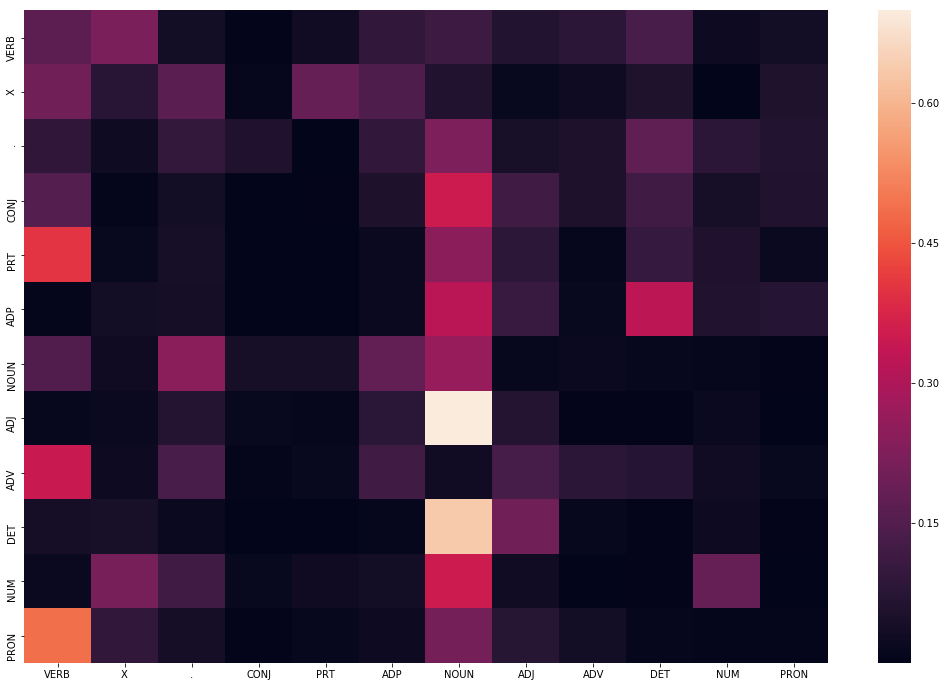

In [20]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

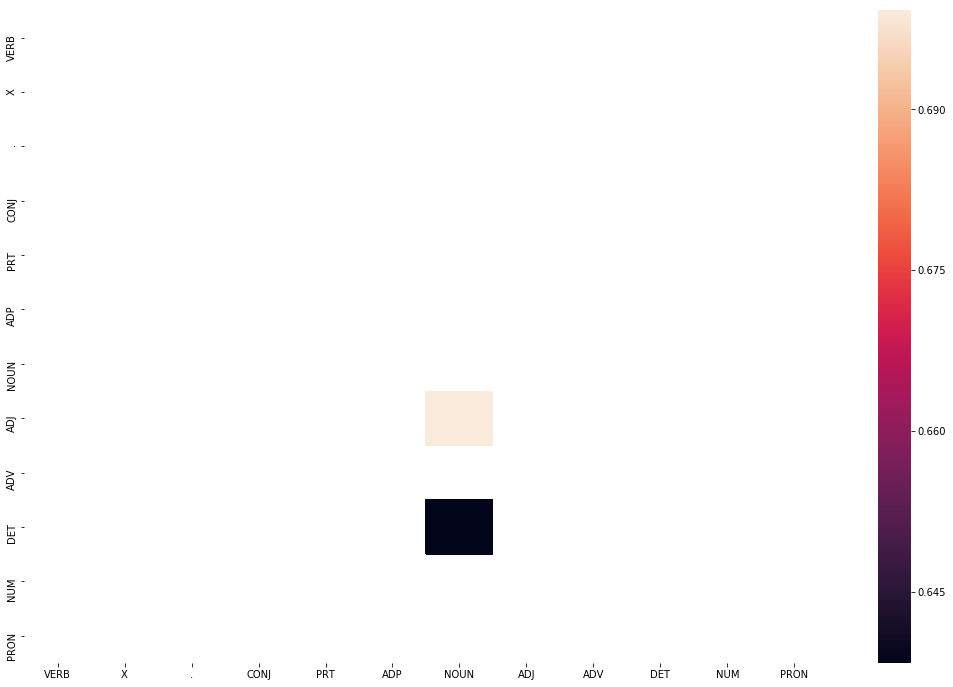

In [21]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

It is seen from the heat map that there is an association with determinant-noun pair and adjective-noun pair as they have a probability greater than 0.5. This shows that the training set has more number of determinant-noun and adjective-noun pairs in it.

### Original Viterbi Algorithm

In [22]:
# Viterbi Heuristic
def Viterbi(words, train_bag = tagged_train_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



#### Evaluating on Validation Set

In [23]:
# choose random 5 sents
rndom = [random.randint(1,len(validation_set)) for x in range(5)]

# list of sents
validation_run = [validation_set[i] for i in rndom]

In [24]:
# list of words and their tags
val_run_base = [tup for sent in validation_run for tup in sent]
val_run_base

[('Trading', 'NOUN'),
 ('was', 'VERB'),
 ('muted', 'VERB'),
 ('*-1', 'X'),
 ('in', 'ADP'),
 ('part', 'NOUN'),
 ('because', 'ADP'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('observance', 'NOUN'),
 ('of', 'ADP'),
 ('All', 'NOUN'),
 ('Saints', 'NOUN'),
 ("'", 'PRT'),
 ('Day', 'NOUN'),
 ('across', 'ADP'),
 ('much', 'ADJ'),
 ('of', 'ADP'),
 ('Europe', 'NOUN'),
 ('.', '.'),
 ('In', 'ADP'),
 ('California', 'NOUN'),
 (',', '.'),
 ('two', 'NUM'),
 ('petition', 'NOUN'),
 ('drives', 'NOUN'),
 ('for', 'ADP'),
 ('next', 'ADJ'),
 ('year', 'NOUN'),
 ("'s", 'PRT'),
 ('election', 'NOUN'),
 ('are', 'VERB'),
 ('``', '.'),
 ('essentially', 'ADV'),
 ('finished', 'VERB'),
 (',', '.'),
 ("''", '.'),
 ('says', 'VERB'),
 ('0', 'X'),
 ('*T*-1', 'X'),
 ('David', 'NOUN'),
 ('Schmidt', 'NOUN'),
 (',', '.'),
 ('author', 'NOUN'),
 ('of', 'ADP'),
 ('``', '.'),
 ('Citizen', 'NOUN'),
 ('Lawmakers', 'NOUN'),
 ('.', '.'),
 ("''", '.'),
 ('Since', 'ADP'),
 ('the', 'DET'),
 ('reforms', 'NOUN'),
 ('went', 'VERB'),
 ('in', 'ADP'),

In [25]:
# list of tagged words
val_tagged_words = [tup[0] for sent in validation_run for tup in sent]
val_tagged_words

['Trading',
 'was',
 'muted',
 '*-1',
 'in',
 'part',
 'because',
 'of',
 'the',
 'observance',
 'of',
 'All',
 'Saints',
 "'",
 'Day',
 'across',
 'much',
 'of',
 'Europe',
 '.',
 'In',
 'California',
 ',',
 'two',
 'petition',
 'drives',
 'for',
 'next',
 'year',
 "'s",
 'election',
 'are',
 '``',
 'essentially',
 'finished',
 ',',
 "''",
 'says',
 '0',
 '*T*-1',
 'David',
 'Schmidt',
 ',',
 'author',
 'of',
 '``',
 'Citizen',
 'Lawmakers',
 '.',
 "''",
 'Since',
 'the',
 'reforms',
 'went',
 'in',
 'place',
 ',',
 'for',
 'example',
 ',',
 'no',
 'state',
 'has',
 'posted',
 'a',
 'higher',
 'rate',
 'of',
 'improvement',
 'on',
 'the',
 'Scholastic',
 'Aptitude',
 'Test',
 'than',
 'South',
 'Carolina',
 '*?*',
 ',',
 'although',
 'the',
 'state',
 'still',
 'posts',
 'the',
 'lowest',
 'average',
 'score',
 'of',
 'the',
 'about',
 '21',
 'states',
 'who',
 '*T*-87',
 'use',
 'the',
 'SAT',
 'as',
 'the',
 'primary',
 'college',
 'entrance',
 'examination',
 '.',
 'Campbell',
 'So

#### Executing the vanilla Viterbi on validation data set

In [26]:
start = time.time()
tagged_val_seq = Viterbi(val_tagged_words)
end = time.time()
difference = end-start

In [27]:
print("Time taken in seconds: ", difference)
print(tagged_val_seq)

Time taken in seconds:  58.90080714225769
[('Trading', 'NOUN'), ('was', 'VERB'), ('muted', 'VERB'), ('*-1', 'X'), ('in', 'ADP'), ('part', 'NOUN'), ('because', 'ADP'), ('of', 'ADP'), ('the', 'DET'), ('observance', 'VERB'), ('of', 'ADP'), ('All', 'DET'), ('Saints', 'VERB'), ("'", 'PRT'), ('Day', 'VERB'), ('across', 'ADP'), ('much', 'ADJ'), ('of', 'ADP'), ('Europe', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('California', 'NOUN'), (',', '.'), ('two', 'NUM'), ('petition', 'NOUN'), ('drives', 'VERB'), ('for', 'ADP'), ('next', 'ADJ'), ('year', 'NOUN'), ("'s", 'PRT'), ('election', 'VERB'), ('are', 'VERB'), ('``', '.'), ('essentially', 'ADV'), ('finished', 'VERB'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('David', 'NOUN'), ('Schmidt', 'VERB'), (',', '.'), ('author', 'NOUN'), ('of', 'ADP'), ('``', '.'), ('Citizen', 'VERB'), ('Lawmakers', 'NOUN'), ('.', '.'), ("''", '.'), ('Since', 'ADP'), ('the', 'DET'), ('reforms', 'NOUN'), ('went', 'VERB'), ('in', 'ADP'), ('place', 'N

#### Accuracy on validation set using vanilla Viterbi algorithm

In [28]:
check = [i for i, j in zip(tagged_val_seq, val_run_base) if i == j] 
accuracy = len(check)/len(tagged_val_seq)
accuracy

0.8742138364779874

#### Incorrect tagged cases of Validation set using vanilla Viterbi algorithm

In [29]:
incorrect_tagged_cases_val_vanilla = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_val_seq, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_val_vanilla

[[('the', 'DET'), (('observance', 'VERB'), ('observance', 'NOUN'))],
 [('of', 'ADP'), (('All', 'DET'), ('All', 'NOUN'))],
 [('All', 'NOUN'), (('Saints', 'VERB'), ('Saints', 'NOUN'))],
 [("'", 'PRT'), (('Day', 'VERB'), ('Day', 'NOUN'))],
 [('petition', 'NOUN'), (('drives', 'VERB'), ('drives', 'NOUN'))],
 [("'s", 'PRT'), (('election', 'VERB'), ('election', 'NOUN'))],
 [('David', 'NOUN'), (('Schmidt', 'VERB'), ('Schmidt', 'NOUN'))],
 [('``', '.'), (('Citizen', 'VERB'), ('Citizen', 'NOUN'))],
 [('the', 'DET'), (('Scholastic', 'VERB'), ('Scholastic', 'NOUN'))],
 [('Scholastic', 'NOUN'), (('Aptitude', 'VERB'), ('Aptitude', 'NOUN'))],
 [('still', 'ADV'), (('posts', 'NOUN'), ('posts', 'VERB'))],
 [('lowest', 'ADJ'), (('average', 'NOUN'), ('average', 'ADJ'))],
 [('who', 'PRON'), (('*T*-87', 'VERB'), ('*T*-87', 'X'))],
 [('the', 'DET'), (('SAT', 'VERB'), ('SAT', 'NOUN'))],
 [('college', 'NOUN'), (('entrance', 'VERB'), ('entrance', 'NOUN'))],
 [('is', 'VERB'), (('furious', 'VERB'), ('furious', 'A

### Test set 

In [30]:
# Reading the Test File
with open('Test_sentences.txt','r') as f:
    lines=f.readlines()
    
# joining lines to form a single string
test_string=reduce(lambda x,y: x+ ' '+y,lines)

#removing extra new line characters
test_string=test_string.replace('\n','') 

#strip white spaces
test_string=test_string.strip() 

# Generating word tokens from sentence
test_tokens=word_tokenize(test_string)

# Generating pos tags for word tokens
test_set = nltk.pos_tag(test_tokens,tagset='universal')
test_set

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('se

#### Executing the vanilla Viterbi on test set

In [31]:
start = time.time()
tagged_test_seq = Viterbi(test_tokens)
end = time.time()
difference = end-start
print(difference)
print(tagged_test_seq)

68.50075578689575
[('Android', 'VERB'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'VERB'), ('.', '.'), ('Android', 'VERB'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'VERB'), ('OS', 'VERB'), ('worldwide', 'VERB'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'VERB'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'VERB'), ('.', '.'), ('Google', 'VERB'), ('and', 'CONJ'), ('Twitter', 'VERB'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'VERB'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'VERB'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'VERB'), ('is', 'VERB'), ('an', 'DET'), ('online', 'VERB'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'

#### Accuracy of test set using vanilla Viterbi algorithm

In [32]:
check = [i for i, j in zip(tagged_test_seq, test_set) if i == j] 
accuracy = len(check)/len(tagged_test_seq)
accuracy

0.7679558011049724

#### Incorrectly tagged words by vanilla Viterbi algorithm on test set

In [33]:
incorrect_tagged_cases_test_vanilla = [[test_set[i-1],j] for i, j in enumerate(zip(tagged_test_seq, test_set)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases_test_vanilla))
incorrect_tagged_cases_test_vanilla

42


[[('.', '.'), (('Android', 'VERB'), ('Android', 'NOUN'))],
 [('by', 'ADP'), (('Google', 'VERB'), ('Google', 'NOUN'))],
 [('.', '.'), (('Android', 'VERB'), ('Android', 'NOUN'))],
 [('the', 'DET'), (('best-selling', 'VERB'), ('best-selling', 'ADJ'))],
 [('best-selling', 'ADJ'), (('OS', 'VERB'), ('OS', 'NOUN'))],
 [('OS', 'NOUN'), (('worldwide', 'VERB'), ('worldwide', 'NOUN'))],
 [('on', 'ADP'), (('smartphones', 'VERB'), ('smartphones', 'NOUN'))],
 [('since', 'ADP'), (('2011', 'VERB'), ('2011', 'NUM'))],
 [('since', 'ADP'), (('2013', 'VERB'), ('2013', 'NUM'))],
 [('.', '.'), (('Google', 'VERB'), ('Google', 'NOUN'))],
 [('and', 'CONJ'), (('Twitter', 'VERB'), ('Twitter', 'NOUN'))],
 [('in', 'ADP'), (('2015', 'VERB'), ('2015', 'NUM'))],
 [('2015', 'NUM'), (('that', 'ADP'), ('that', 'DET'))],
 [('gave', 'VERB'), (('Google', 'VERB'), ('Google', 'NOUN'))],
 [('to', 'PRT'), (('Twitter', 'VERB'), ('Twitter', 'NOUN'))],
 [("'s", 'PRT'), (('firehose', 'VERB'), ('firehose', 'NOUN'))],
 [('.', '.'), 

**Insight** : 

The original Viterbi algorithm has __40-50__ words incorrectly pos tagged.

### Solve the problem of unknown words


#### List of unknown words

In [34]:
# Train data
vocabulary=(set([pair[0] for pair in tagged_train_words]))

# Validation data
tagged_words_validation=[tup for ls in validation_set for tup in ls]
vocabulary_validation=set([t[0] for t in tagged_words_validation])

# Test data
vocabulary_test = set([t[0] for t in test_set])

# Length of each data set
print(len(vocabulary),' ',len(vocabulary_validation),' ',len(vocabulary_test))

12059   2008   115


In [35]:
print("Vocabulary which is not part of Training Set but part of Validation Set")
Validation_unknownwords=list(vocabulary_validation-vocabulary)
print("Total Unknown words: {}, sample->{}".format(len(Validation_unknownwords),Validation_unknownwords[0:10]))

Vocabulary which is not part of Training Set but part of Validation Set
Total Unknown words: 349, sample->['PAP', 'riding', 'Malizia', 'handles', '877,663', 'SOYBEANS', 'distinct', 'product-design', '1\\/10th', 'regime']


In [36]:
print("Vocabulary which is not part of Training Set but part of Test Set")
Test_unknownwords=list(vocabulary_test-vocabulary)
print("Total Unknown words: {}, sample->{}".format(len(Test_unknownwords),Test_unknownwords[0:10]))

Vocabulary which is not part of Training Set but part of Test Set
Total Unknown words: 30, sample->['Satellite', '21st', 'Android', 'Twitter', '2018', '2015', 'messages', 'best-selling', 'worldwide', 'domineering']


### Exploratory data analysis

In [37]:
# POS tags of unknown words in validation set
[tup for tup in tagged_val_seq for word in Validation_unknownwords if tup[0]==word ]

[('muted', 'VERB'),
 ('observance', 'VERB'),
 ('Saints', 'VERB'),
 ('Day', 'VERB'),
 ('drives', 'VERB'),
 ('election', 'VERB'),
 ('Schmidt', 'VERB'),
 ('Citizen', 'VERB'),
 ('Scholastic', 'VERB'),
 ('Aptitude', 'VERB'),
 ('*T*-87', 'VERB'),
 ('SAT', 'VERB'),
 ('entrance', 'VERB'),
 ('furious', 'VERB'),
 ('microwave', 'VERB'),
 ('column', 'VERB'),
 ('Runkel', 'VERB')]

In [38]:
# POS tags of unknown words in test set
[tup for tup in tagged_test_seq for word in Test_unknownwords if tup[0]==word ]

[('Android', 'VERB'),
 ('Google', 'VERB'),
 ('Android', 'VERB'),
 ('best-selling', 'VERB'),
 ('OS', 'VERB'),
 ('worldwide', 'VERB'),
 ('smartphones', 'VERB'),
 ('2011', 'VERB'),
 ('2013', 'VERB'),
 ('Google', 'VERB'),
 ('Twitter', 'VERB'),
 ('2015', 'VERB'),
 ('Google', 'VERB'),
 ('Twitter', 'VERB'),
 ('firehose', 'VERB'),
 ('Twitter', 'VERB'),
 ('online', 'VERB'),
 ('interact', 'VERB'),
 ('messages', 'VERB'),
 ('tweets', 'VERB'),
 ('domineering', 'VERB'),
 ('personality', 'VERB'),
 ('2018', 'VERB'),
 ('FIFA', 'VERB'),
 ('Cup', 'VERB'),
 ('21st', 'VERB'),
 ('FIFA', 'VERB'),
 ('Cup', 'VERB'),
 ('tournament', 'VERB'),
 ('contested', 'VERB'),
 ('Cup', 'VERB'),
 ('11th', 'VERB'),
 ('trips', 'VERB'),
 ('arriving', 'VERB'),
 ('NASA', 'VERB'),
 ('invited', 'VERB'),
 ('ICESAT-2', 'VERB'),
 ('Satellite', 'VERB')]

In [39]:
# Count of all tags in the training set

tag_counts = Counter(pair[1] for pair in tagged_train_words)
tag_counts

Counter({'DET': 8279,
         'NOUN': 27356,
         'VERB': 12845,
         'ADP': 9344,
         'ADJ': 6031,
         '.': 11152,
         'X': 6268,
         'PRON': 2609,
         'ADV': 3002,
         'NUM': 3359,
         'CONJ': 2139,
         'PRT': 3037})

In [40]:
# Five most common tags in training set
tag_counts.most_common(5)

[('NOUN', 27356), ('VERB', 12845), ('.', 11152), ('ADP', 9344), ('DET', 8279)]

In [41]:
# Count of incorrectly classfied words for each tag in validation set
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases_val_vanilla)
wrong_tag_counts

Counter({'VERB': 16, 'DET': 1, 'NOUN': 2, 'ADP': 1})

In [42]:
# Count of incorrectly classfied words for each tag in test set
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases_test_vanilla)
wrong_tag_counts

Counter({'VERB': 36, 'ADP': 3, 'NOUN': 3})

#### Determine the rules for rule based technique

In [43]:
# Check the percentage of verbs which are classifed as 'VERB' which end with 'ed'
verbs = [pair for pair in tagged_train_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:10]

0.20591669910471


[('disclosed', 'VERB'),
 ('offered', 'VERB'),
 ('totaled', 'VERB'),
 ('barred', 'VERB'),
 ('noted', 'VERB'),
 ('suspended', 'VERB'),
 ('consented', 'VERB'),
 ('launched', 'VERB'),
 ('engineered', 'VERB'),
 ('lengthened', 'VERB')]

**Finding :** 21% words in the training set are verbs which end with 'ed'

In [44]:
# Check the percentage of verbs which are classifed as 'VERB' which end with 'ing'
verbs = [pair for pair in tagged_train_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:10]

0.10844686648501363


[('limiting', 'VERB'),
 ('admitting', 'VERB'),
 ('denying', 'VERB'),
 ('apologizing', 'VERB'),
 ('making', 'VERB'),
 ('indulging', 'VERB'),
 ('according', 'VERB'),
 ('worrying', 'VERB'),
 ('manufacturing', 'VERB'),
 ('According', 'VERB')]

**Finding :** ~11% words in the training set are verbs which end with 'ing'

In [45]:
# Check the percentage of verbs which are classifed as 'VERB' which end with 'es'
verbs = [pair for pair in tagged_train_words if pair[1]=='VERB']
es_verbs = [pair for pair in verbs if pair[0].endswith('es')]
print(len(es_verbs) / len(verbs))
es_verbs[:10]

0.02631374075515765


[('involves', 'VERB'),
 ('comes', 'VERB'),
 ('becomes', 'VERB'),
 ('acquires', 'VERB'),
 ('gives', 'VERB'),
 ('refuses', 'VERB'),
 ('retires', 'VERB'),
 ('publishes', 'VERB'),
 ('does', 'VERB'),
 ('declines', 'VERB')]

**Finding :** ~3% words in the training set are verbs which end with 'es'

In [46]:
# Check the percentage of adverbs which are classifed as 'ADV' which end with 'ly'
advs = [pair for pair in tagged_train_words if pair[1]=='ADV']
ly_advs = [pair for pair in advs if pair[0].endswith('ly')]
print(len(ly_advs) / len(advs))
ly_advs[:10]

0.2808127914723518


[('publicly', 'ADV'),
 ('indefinitely', 'ADV'),
 ('vertically', 'ADV'),
 ('globally', 'ADV'),
 ('easily', 'ADV'),
 ('highly', 'ADV'),
 ('temporarily', 'ADV'),
 ('only', 'ADV'),
 ('consistently', 'ADV'),
 ('generally', 'ADV')]

**Finding :** 28% words in the training set are adverbs which end with 'ly'

In [47]:
# Check the percentage of verbs which are classifed as 'ADJ' which end with 'able'
adjs = [pair for pair in tagged_train_words if pair[1]=='ADJ']
able_adjs = [pair for pair in adjs if pair[0].endswith('able')]
print(len(able_adjs) / len(adjs))
able_adjs[:10]

0.019565577847786435


[('profitable', 'ADJ'),
 ('distributable', 'ADJ'),
 ('sizable', 'ADJ'),
 ('able', 'ADJ'),
 ('questionable', 'ADJ'),
 ('able', 'ADJ'),
 ('able', 'ADJ'),
 ('salable', 'ADJ'),
 ('favorable', 'ADJ'),
 ('non-callable', 'ADJ')]

**Finding :** ~2% of words in the training set are adjectives which end with 'able'

From the heat map, we see that adjectives(ADJ) and determinants(DET) have a association with Noun in the training set. Lets see the pattern these POS tags follow

In [48]:
# Calculate the percentage of adjective tags followed by nouns

# create a list of all tags from the training list
tags = [pair[1] for pair in tagged_train_words]

# create a list of ADJ tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_noun_tags) / len(adj_tags))

0.6992206930857238


**Finding :** Around 70% of adjectives are followed by Nouns

In [49]:
# Check the percentage of determinant tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_noun_tags) / len(dt_tags))

0.6383621210291098


**Finding :** Around 64% of determinants are followed by Nouns

## Modify Viterbi Algorithm

### Method 1 : Rule based technique

**From the EDA performed above, we see the following rules deem fit for modifying Viterbi algorithm using rule based technique**

In [50]:
# specify morphological patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),                       # gerund
    (r'.*ed$', 'VERB'),                        # past tense
    (r'.*es$', 'VERB'),                        # 3rd singular present
    (r'.*able$', 'ADJ'),                       # adjectives  
    (r'.*\'s$', 'NOUN'),                       # possessive nouns
    (r'.*s$', 'NOUN'),                         # plural nouns
    (r'[0-9]{4}', 'NUM'),                      # year to be represented as numbers
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),          # cardinal numbers
    (r'.*ly$', 'ADV'),                         # adverbs
    (r'^\*.*', 'X'),                           # foreign words
    (r'.*', 'NOUN')                            # nouns
]

In [51]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
unigram_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

# bigram tagger backed up by the unigram tagger
rule_based_tagger = nltk.BigramTagger(train_set, backoff=unigram_tagger)

In [52]:
# Accuracy of the rule based tagger on validation set
rule_based_tagger.evaluate(validation_set)

0.9552806850618458

In [53]:
#rule_based_tagger.tag(Validation_unknownwords)

In [54]:
#rule_based_tagger.tag(Test_unknownwords)

In [55]:
# Modified Viterbi Heuristic
def Viterbi_updated1(words, train_bag = tagged_train_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If True, the word is unknown and the tag is updated based on the customised pos tagger
            state_max = rule_based_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy on Validation set for method 1

In [56]:
# Tagging the validation sentences with the updated Viterbi algorithm using method 1
start = time.time()
updated_val_tagged_seq1 = Viterbi_updated1(val_tagged_words)
end = time.time()

# Total time taken to train the algorithm
difference = end-start
print(difference)

# Updated tagged validation set
print(updated_val_tagged_seq1)

59.13756227493286
[('Trading', 'NOUN'), ('was', 'VERB'), ('muted', 'VERB'), ('*-1', 'X'), ('in', 'ADP'), ('part', 'NOUN'), ('because', 'ADP'), ('of', 'ADP'), ('the', 'DET'), ('observance', 'NOUN'), ('of', 'ADP'), ('All', 'DET'), ('Saints', 'NOUN'), ("'", 'PRT'), ('Day', 'NOUN'), ('across', 'ADP'), ('much', 'ADJ'), ('of', 'ADP'), ('Europe', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('California', 'NOUN'), (',', '.'), ('two', 'NUM'), ('petition', 'NOUN'), ('drives', 'VERB'), ('for', 'ADP'), ('next', 'ADJ'), ('year', 'NOUN'), ("'s", 'PRT'), ('election', 'NOUN'), ('are', 'VERB'), ('``', '.'), ('essentially', 'ADV'), ('finished', 'VERB'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('David', 'NOUN'), ('Schmidt', 'NOUN'), (',', '.'), ('author', 'NOUN'), ('of', 'ADP'), ('``', '.'), ('Citizen', 'NOUN'), ('Lawmakers', 'NOUN'), ('.', '.'), ("''", '.'), ('Since', 'ADP'), ('the', 'DET'), ('reforms', 'NOUN'), ('went', 'VERB'), ('in', 'ADP'), ('place', 'NOUN'), (',', '.'), ('for

#### Accuracy on validation set for the updated Viterbi algorithm using method 1

In [57]:
check = [i for i, j in zip(updated_val_tagged_seq1, val_run_base) if i == j] 
accuracy = len(check)/len(updated_val_tagged_seq1)
accuracy

0.9622641509433962

#### Evaluating tagging accuracy on Test set for method 1

In [58]:
# Tagging the test sentences with the updated Viterbi algorithm using method 1
start = time.time()
updated_test_tagged_seq1 = Viterbi_updated1(test_tokens)
end = time.time()

# Total time taken to train the algorithm
difference = end-start
print(difference)

# Updated tagged test set
print(updated_test_tagged_seq1)

70.85744166374207
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'VERB'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), 

#### Accuracy on test set for the updated Viterbi algorithm using method 1

In [59]:
check = [i for i, j in zip(updated_test_tagged_seq1, test_set) if i == j] 
accuracy = len(check)/len(updated_test_tagged_seq1)
accuracy

0.9226519337016574

#### Incorrectly tagged words by the updated Viterbi algorithm using method 1

In [60]:
incorrect_tagged_cases = [j for i, j in enumerate(zip(updated_test_tagged_seq1, test_set)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

14


[(('best-selling', 'VERB'), ('best-selling', 'ADJ')),
 (('smartphones', 'VERB'), ('smartphones', 'NOUN')),
 (('that', 'ADP'), ('that', 'DET')),
 (('online', 'NOUN'), ('online', 'ADJ')),
 (('messages', 'VERB'), ('messages', 'NOUN')),
 (('domineering', 'VERB'), ('domineering', 'ADJ')),
 (('21st', 'NOUN'), ('21st', 'NUM')),
 (('11th', 'NOUN'), ('11th', 'NUM')),
 (('Show', 'NOUN'), ('Show', 'VERB')),
 (('like', 'ADP'), ('like', 'VERB')),
 (('Show', 'NOUN'), ('Show', 'VERB')),
 (('about', 'ADP'), ('about', 'ADV')),
 (('arriving', 'VERB'), ('arriving', 'NOUN')),
 (('experience', 'NOUN'), ('experience', 'VERB'))]

**Insight** :

The original Viterbi algorithm has __40+__ words incorrectly pos tagged while the modified Viterbi algorithm using method 1 has __only 14__ words incorrectly pos tagged.

### Method 2: Probability based approach for unknown words

We know that the emission probability of an unknown word is zero. Taking this into account, we calculate the state probability using only transition probability for unknown words and rest of the words consider the state probability as a product of emission and transition probabilities.

In [61]:
# Modified Viterbi Heuristic
def Viterbi_updated2(words, test_bag, train_bag = tagged_train_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            # Check if the word belongs to the unknown words list
            if word in test_bag:
                # If True, choose state probability = transition probability as emission probability for unknown words is zero.
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy on Validation set for method 2

In [62]:
# Tagging the validation sentences with the updated Viterbi algorithm using method 2
start = time.time()
updated_val_tagged_seq2 = Viterbi_updated2(val_tagged_words, Validation_unknownwords)
end = time.time()

# Total time taken to train the algorithm
difference = end-start
print(difference)

# Updated tagged validation set
print(updated_val_tagged_seq2)

75.11507964134216
[('Trading', 'NOUN'), ('was', 'VERB'), ('muted', 'X'), ('*-1', 'X'), ('in', 'ADP'), ('part', 'NOUN'), ('because', 'ADP'), ('of', 'ADP'), ('the', 'DET'), ('observance', 'NOUN'), ('of', 'ADP'), ('All', 'DET'), ('Saints', 'NOUN'), ("'", 'PRT'), ('Day', 'VERB'), ('across', 'ADP'), ('much', 'ADJ'), ('of', 'ADP'), ('Europe', 'NOUN'), ('.', '.'), ('In', 'ADP'), ('California', 'NOUN'), (',', '.'), ('two', 'NUM'), ('petition', 'NOUN'), ('drives', 'NOUN'), ('for', 'ADP'), ('next', 'ADJ'), ('year', 'NOUN'), ("'s", 'PRT'), ('election', 'VERB'), ('are', 'VERB'), ('``', '.'), ('essentially', 'ADV'), ('finished', 'VERB'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('David', 'NOUN'), ('Schmidt', 'NOUN'), (',', '.'), ('author', 'NOUN'), ('of', 'ADP'), ('``', '.'), ('Citizen', 'NOUN'), ('Lawmakers', 'NOUN'), ('.', '.'), ("''", '.'), ('Since', 'ADP'), ('the', 'DET'), ('reforms', 'NOUN'), ('went', 'VERB'), ('in', 'ADP'), ('place', 'NOUN'), (',', '.'), ('for', 

#### Accuracy on validation set for the updated Viterbi algorithm using method 2

In [63]:
check = [i for i, j in zip(updated_val_tagged_seq2, val_run_base) if i == j] 
accuracy = len(check)/len(updated_val_tagged_seq2)
accuracy

0.9433962264150944

#### Evaluating tagging accuracy on Test set for method 2

In [64]:
# Tagging the test sentences with the updated Viterbi algorithm using method 2
start = time.time()
updated_test_tagged_seq2 = Viterbi_updated2(test_tokens,Test_unknownwords)
end = time.time()

# Total time taken to train the algorithm
difference = end-start
print(difference)

# Updated tagged test set
print(updated_test_tagged_seq2)

69.15784549713135
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'NOUN'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('whi

#### Accuracy on test set for the updated Viterbi algorithm using method 2

In [65]:
check = [i for i, j in zip(updated_test_tagged_seq2, test_set) if i == j] 
accuracy = len(check)/len(updated_test_tagged_seq2)
accuracy

0.856353591160221

#### Incorrectly tagged words by the updated Viterbi algorithm using method 2

In [66]:
incorrect_tagged_cases = [j for i, j in enumerate(zip(updated_test_tagged_seq2, test_set)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

26


[(('Google', 'DET'), ('Google', 'NOUN')),
 (('best-selling', 'NOUN'), ('best-selling', 'ADJ')),
 (('smartphones', 'DET'), ('smartphones', 'NOUN')),
 (('2011', 'DET'), ('2011', 'NUM')),
 (('2013', 'DET'), ('2013', 'NUM')),
 (('2015', 'DET'), ('2015', 'NUM')),
 (('that', 'ADP'), ('that', 'DET')),
 (('Google', 'X'), ('Google', 'NOUN')),
 (('Twitter', 'VERB'), ('Twitter', 'NOUN')),
 (('firehose', 'VERB'), ('firehose', 'NOUN')),
 (('online', 'NOUN'), ('online', 'ADJ')),
 (('messages', 'DET'), ('messages', 'NOUN')),
 (('known', 'ADJ'), ('known', 'VERB')),
 (('tweets', 'DET'), ('tweets', 'NOUN')),
 (('domineering', 'NOUN'), ('domineering', 'ADJ')),
 (('2018', 'NOUN'), ('2018', 'NUM')),
 (('21st', 'NOUN'), ('21st', 'NUM')),
 (('contested', 'NOUN'), ('contested', 'VERB')),
 (('11th', 'NOUN'), ('11th', 'NUM')),
 (('Show', 'NOUN'), ('Show', 'VERB')),
 (('like', 'ADP'), ('like', 'VERB')),
 (('Show', 'NOUN'), ('Show', 'VERB')),
 (('about', 'ADP'), ('about', 'ADV')),
 (('invited', 'NOUN'), ('invited

**Insight** : 

The original Viterbi algorithm has __40+__ words incorrectly pos tagged while the modified Viterbi algorithm using method 2 has __26__ words incorrectly pos tagged.

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

##### Accuracy on validation and test set using the original Viterbi algorithm

In [67]:
# Validation set with vanilla Viterbi algorithm
check = [i for i, j in zip(tagged_val_seq, val_run_base) if i == j] 
accuracy = len(check)/len(tagged_val_seq)
accuracy

0.8742138364779874

In [68]:
# Test set with vanilla Viterbi algorithm
check = [i for i, j in zip(tagged_test_seq, test_set) if i == j] 
accuracy = len(check)/len(tagged_test_seq)
accuracy

0.7679558011049724

##### Accuracy on validation and test set using the modified Viterbi algorithm with rules based approach (method 1)

In [69]:
# Validation set with rule based Viterbi algorithm
check = [i for i, j in zip(updated_val_tagged_seq1, val_run_base) if i == j] 
accuracy = len(check)/len(updated_val_tagged_seq1)
accuracy

0.9622641509433962

In [70]:
# Test set with rule based Viterbi algorithm
check = [i for i, j in zip(updated_test_tagged_seq1, test_set) if i == j] 
accuracy = len(check)/len(updated_test_tagged_seq1)
accuracy

0.9226519337016574

##### Accuracy on validation and test set using the modified Viterbi algorithm with probability based approach for unknown words. (method 2)

In [71]:
# Validation set with probability based Viterbi algorithm
check = [i for i, j in zip(updated_val_tagged_seq2, val_run_base) if i == j] 
accuracy = len(check)/len(updated_val_tagged_seq2)
accuracy

0.9433962264150944

In [72]:
# Test set with probability based Viterbi algorithm
check = [i for i, j in zip(updated_test_tagged_seq2, test_set) if i == j] 
accuracy = len(check)/len(updated_test_tagged_seq2)
accuracy

0.856353591160221

### Conclusion

We see __8-11% increase__ using the rule-based pos tagger and __6-9% increase__ using the probability-based method in validation set compared to the original Viterbi algorithm

Similarly, we see __15-18% increase__ using the rule-based pos tagger and __9-12% increase__ using the probability-based method in test set compared to the original Viterbi algorithm




### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

List of incorrectly tagged words by the original POS tagger

In [73]:
incorrect_tagged_cases_test_vanilla = [j for i, j in enumerate(zip(tagged_test_seq, test_set)) if j[0]!=j[1]]
incorrect_tagged_cases_test_vanilla

[(('Android', 'VERB'), ('Android', 'NOUN')),
 (('Google', 'VERB'), ('Google', 'NOUN')),
 (('Android', 'VERB'), ('Android', 'NOUN')),
 (('best-selling', 'VERB'), ('best-selling', 'ADJ')),
 (('OS', 'VERB'), ('OS', 'NOUN')),
 (('worldwide', 'VERB'), ('worldwide', 'NOUN')),
 (('smartphones', 'VERB'), ('smartphones', 'NOUN')),
 (('2011', 'VERB'), ('2011', 'NUM')),
 (('2013', 'VERB'), ('2013', 'NUM')),
 (('Google', 'VERB'), ('Google', 'NOUN')),
 (('Twitter', 'VERB'), ('Twitter', 'NOUN')),
 (('2015', 'VERB'), ('2015', 'NUM')),
 (('that', 'ADP'), ('that', 'DET')),
 (('Google', 'VERB'), ('Google', 'NOUN')),
 (('Twitter', 'VERB'), ('Twitter', 'NOUN')),
 (('firehose', 'VERB'), ('firehose', 'NOUN')),
 (('Twitter', 'VERB'), ('Twitter', 'NOUN')),
 (('online', 'VERB'), ('online', 'ADJ')),
 (('interact', 'VERB'), ('interact', 'NOUN')),
 (('messages', 'VERB'), ('messages', 'NOUN')),
 (('tweets', 'VERB'), ('tweets', 'NOUN')),
 (('domineering', 'VERB'), ('domineering', 'ADJ')),
 (('personality', 'VERB'),

The following unknown word-tag pairs are corrected by the modified viterbi algorithm using

### Method 1: Rule based approach 

**1. 'Android, Google, worldwide'**

'Android','Google' and ' worldwide' were unknown words. They were incorrectly tagged in the original viterbi algorithm. However, the modified Viterbi algorithms correctly classified them as __Nouns__ 

**2. '2011,2013'**

Words like '2011' and '2013' were incorrectly classified with the original algorithm. Because we used rule based tagger as backoff tagger and we have rule for indicating cardinal numbers such as year to numbers. Hence, '2011' and '2013' is correctly tagged as __Number(NUM)__ by the updated viterbi algorithm

**3. 'NASA,CESAT-2,Satellite.'**

'NASA', 'ICESAT-2' and 'Satellite' were unknown words which were incorrectly classified by the original 
Viterbi algorithm. They are correctly classified as __Nouns__ in the updated Viterbi algorithm.

### Method 2: Probability based approach 

**1. 'Android, worldwide'**

'Android' and ' worldwide' were unknown words. They were incorrectly tagged in the original viterbi algorithm. However, the updated Viterbi algorithms correctly classified them as __Nouns__ 

**2. 'NASA,Satellite'**

'NASA' and 'Satellite' were unknown words which were incorrectly classified by the original Viterbi algorithm. They are correctly classified as __Nouns__ in the updated Viterbi algorithm.

**3. 'personality,tournament'**

'Personality' and 'Tournament' were unknown words which were incorrectly classified by the original Viterbi algorithm. They are correctly classified as __Nouns__ in the updated Viterbi algorithm.